# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from PMF import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "Sparse"

# Source Generation and Mixing Scenario

In [2]:
N = 10000
NumberofSources = 5
NumberofMixtures = 10
Sgt = generate_correlated_copula_sources(
    rho=0.0,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=True,
)
Sgt = 4 * Sgt - 2
Sgt = np.clip(ProjectRowstoL1NormBall(Sgt.T).T, 0, 1)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(Sgt))

# Generate Mxr random mixing from i.i.d N(0,1)
Agt = np.random.randn(NumberofMixtures, NumberofSources)
Y = np.dot(Agt, Sgt)

SNR = 30
Y, NoisePart = addWGN(Y, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Y - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(Agt)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.975047294048455


# Visualize Generated Sources and Mixtures

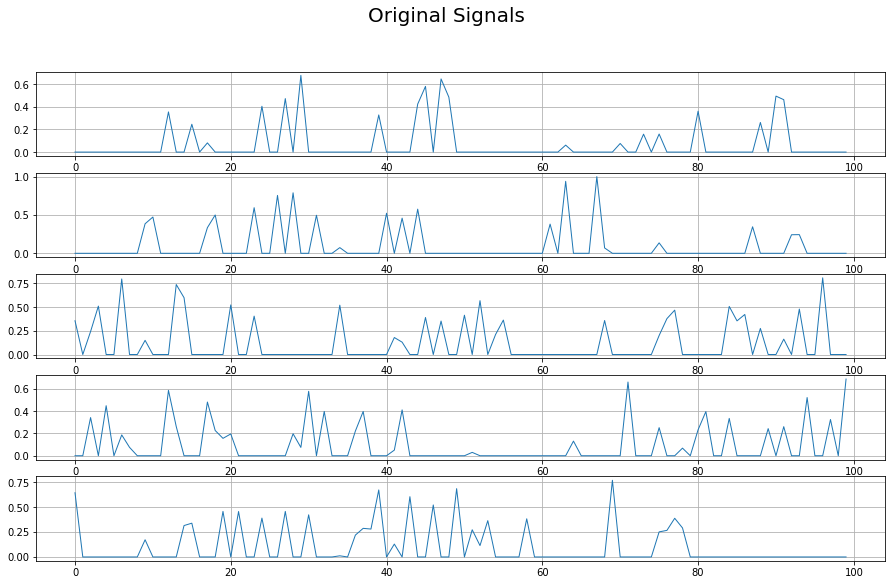

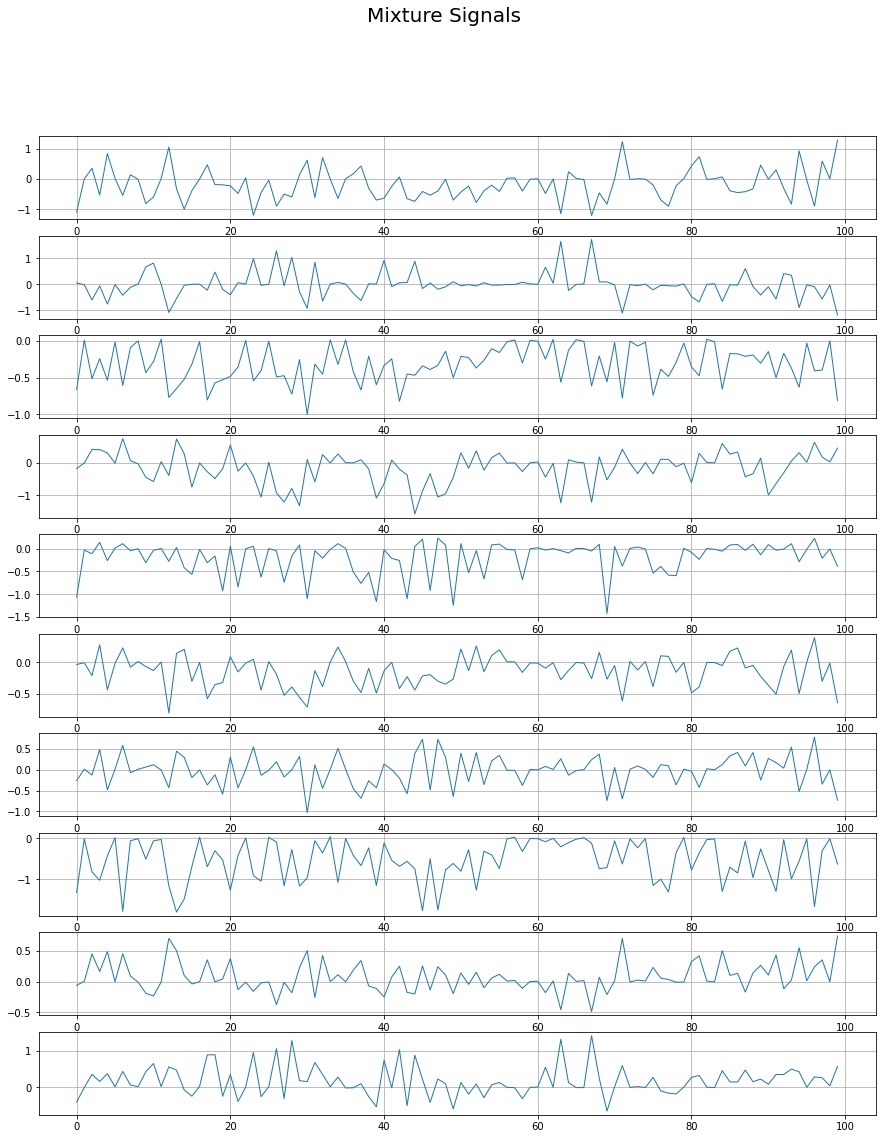

In [3]:
subplot_1D_signals(
    Sgt[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    Y[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
s_dim = Sgt.shape[0]
y_dim = Y.shape[0]
debug_iteration_point = 25000
model = PMFv2(s_dim=s_dim, y_dim=y_dim, set_ground_truth=True, Sgt=Sgt, Agt=Agt)

# Run PMF Algorithm on Mixture Signals

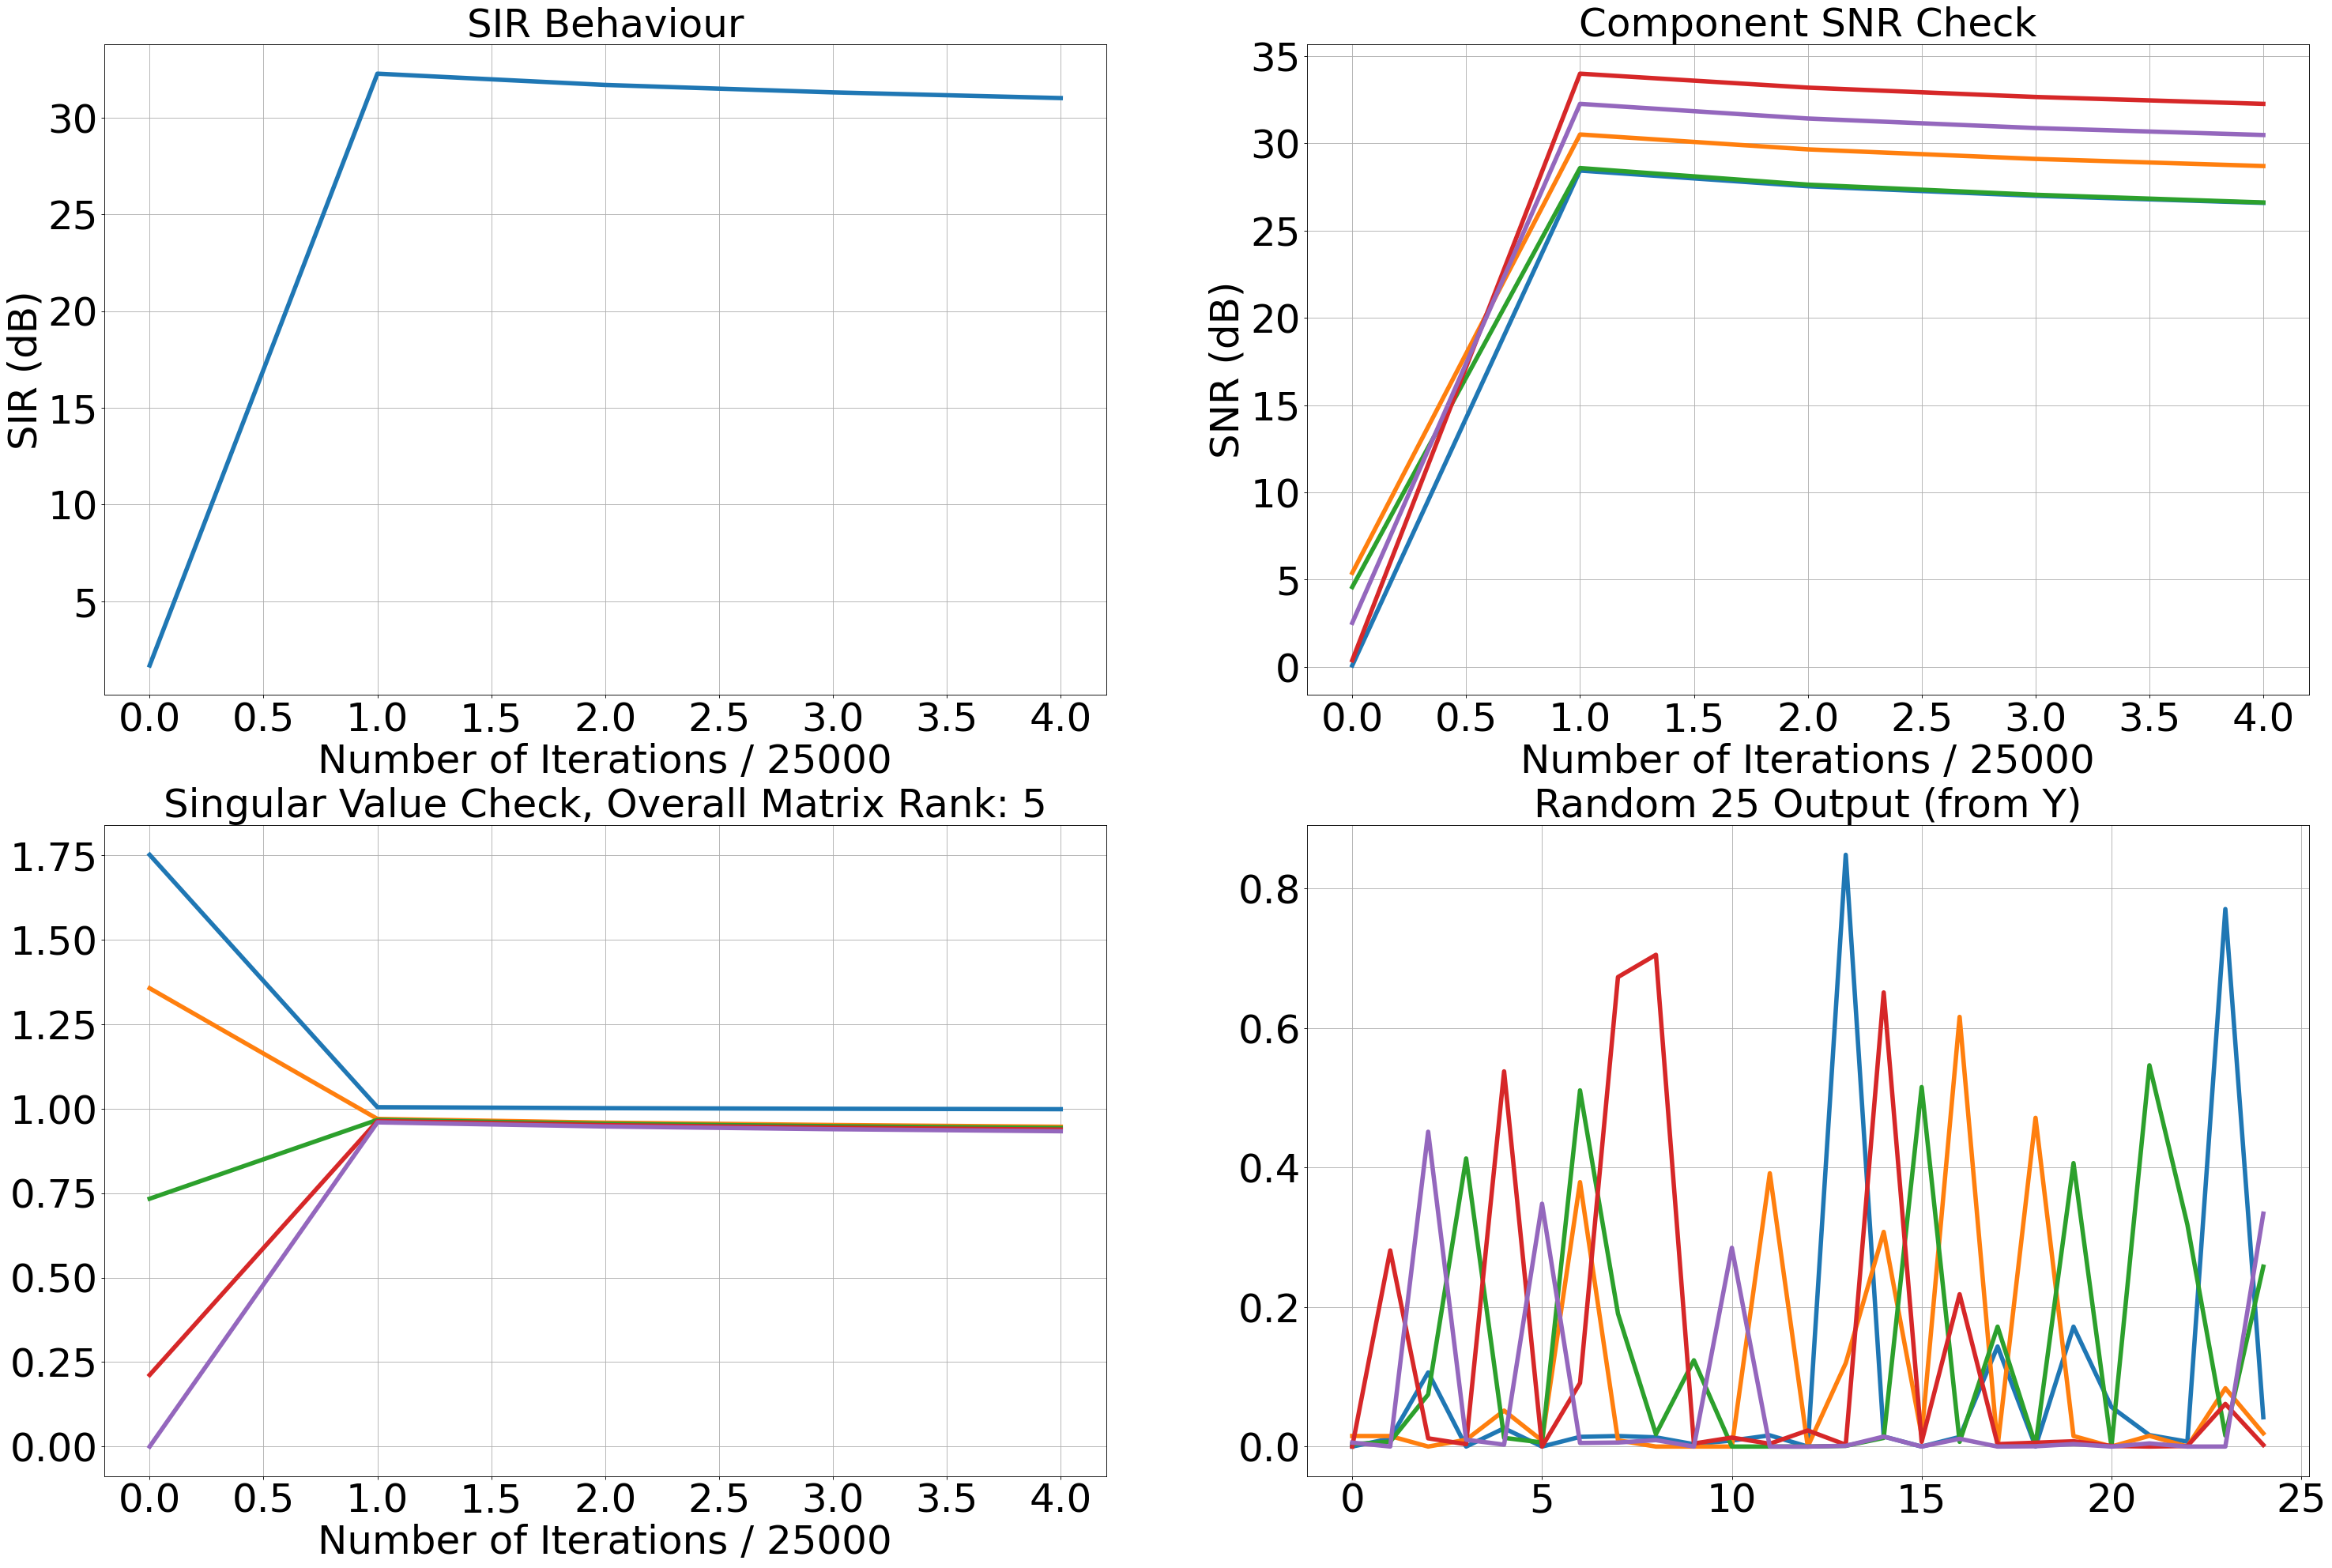

100%|██████████| 100000/100000 [04:11<00:00, 397.73it/s]


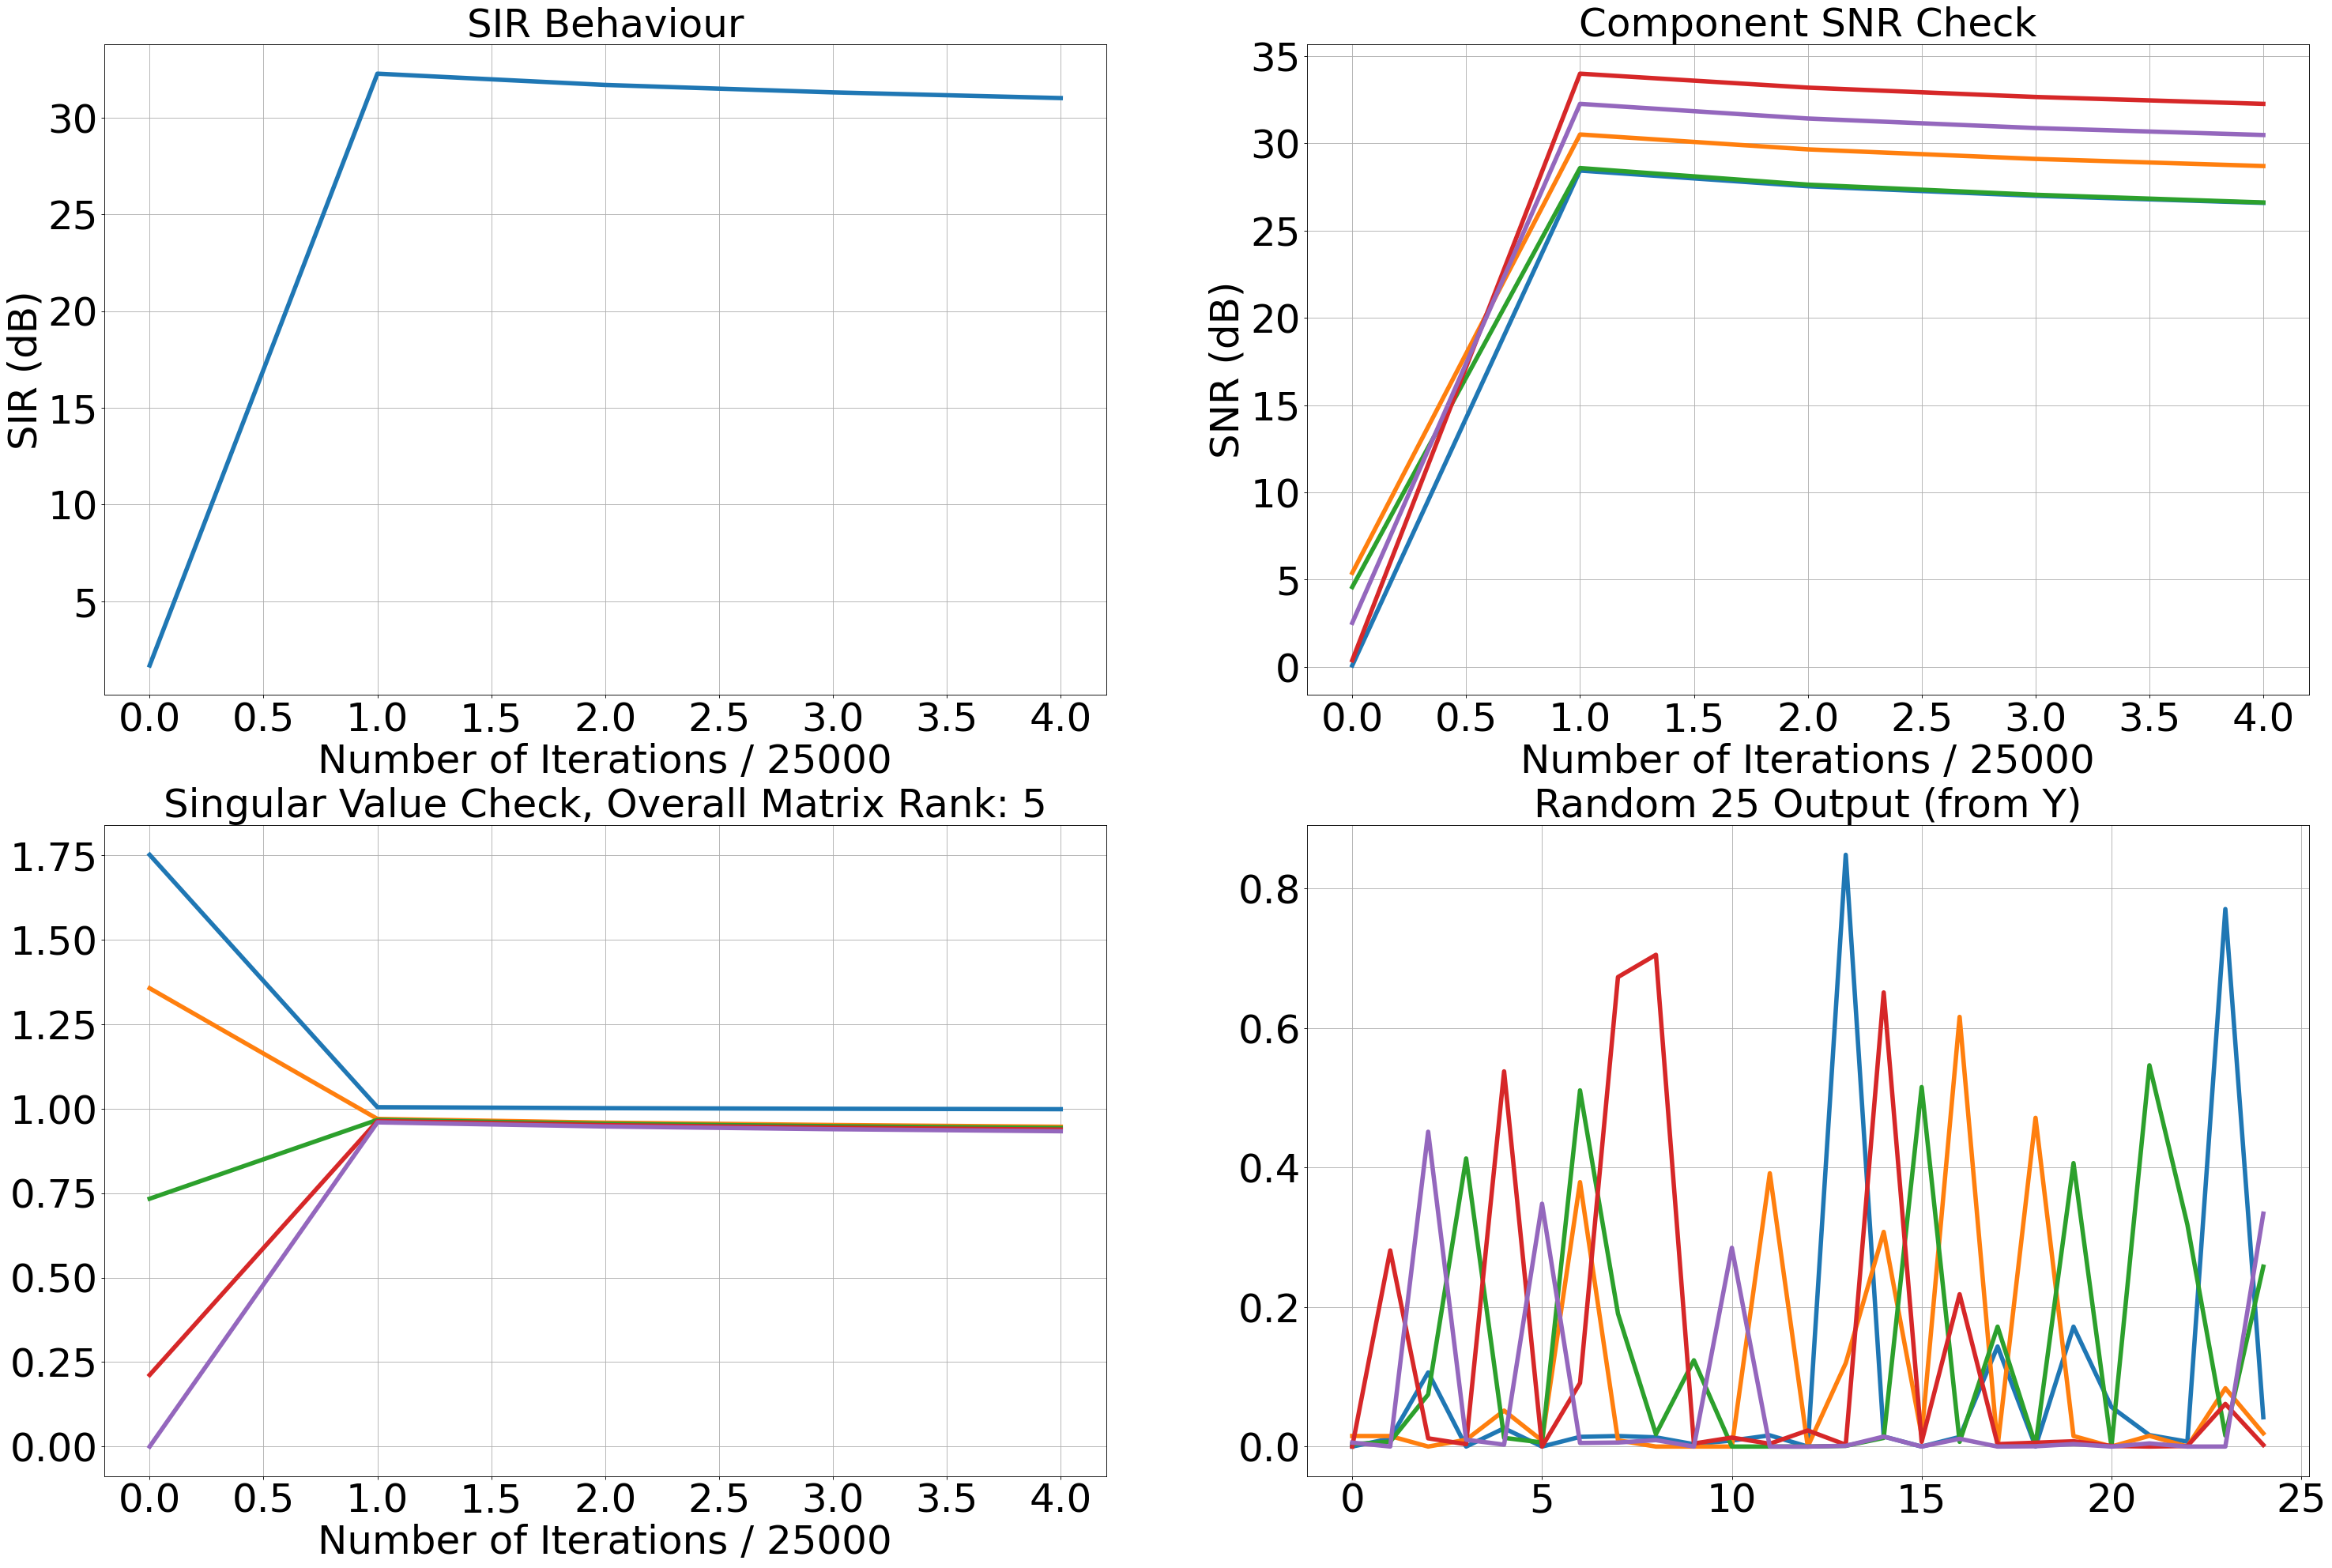

In [5]:
model.fit_batch_nnsparse(
    Y,
    n_iterations=100000,
    step_size_scale=100,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Calculate Resulting Component SNRs and Overall SINR

In [6]:
Y = model.S
Y_ = signed_and_permutation_corrected_sources(Sgt, Y)
coef_ = ((Y_ * Sgt).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Sgt, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, Sgt)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [26.59154019 28.70348009 26.61537141 32.26756184 30.48238672]

Overall SINR : 31.011433406612635


# Vizualize Extracted Signals Compared to Original Sources

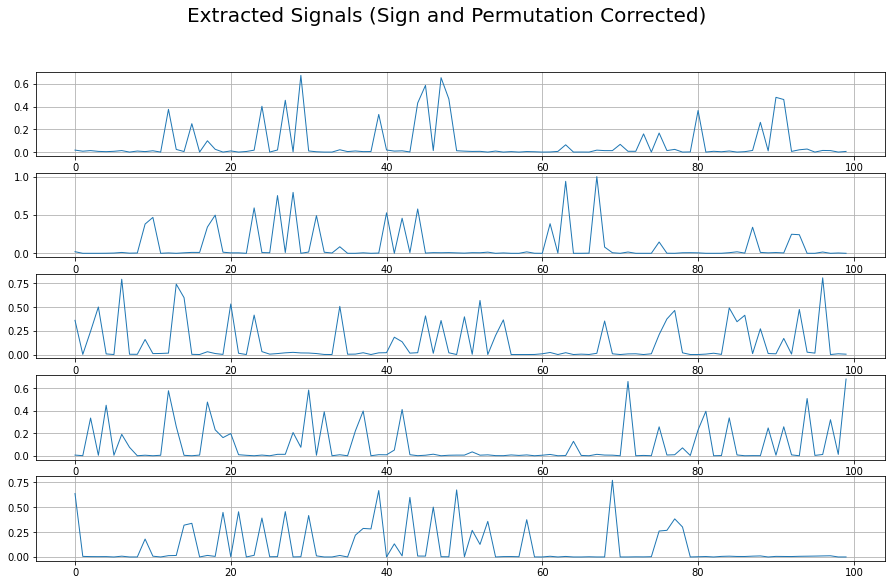

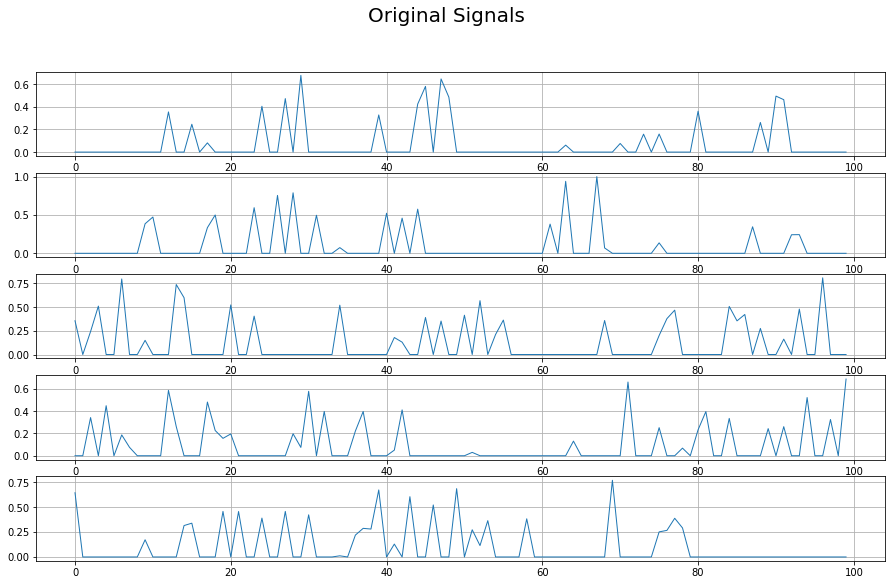

In [7]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    Sgt[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)